In [43]:
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as f
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,    # vocabulary size
    'context_length': 256,  # Context Length
    'emb_dim': 768,         # Embedding dimension
    'n_heads': 12,          # Number of attention heads
    'n_layers': 12,         # Number of layers
    'drop_rate': 0.1,       # Dropout rate
    'qkv_bias': False       # Query-Key-Value bias
}

tokenizer = tiktoken.get_encoding('gpt2')

In [3]:
with open('the-verdict.txt', 'r', encoding='utf-8') as f:
    text_data = f.read()

text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

## GPT2 Model From Scratch

#### Utils

In [4]:
class LayerNorm(nn.Module):
    
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [5]:
class GELU(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2/torch.pi)) * 
            (x + 0.44715 * torch.pow(x, 3))
        ))

In [6]:
class FeedForward(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']), ## Expansion
            GELU(),                                        ## Activation
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])    ## Contraction
        )
    
    def forward(self, x):
        return self.layers(x)

In [7]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads == 0), 'd_out must be divisible by num_heads'
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        self.Wq = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.Wk = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.Wv = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_in) # Linear layer to combine head outputs
        self.droput = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        # (b, num_tokens, d_out)
        queries = self.Wq(x)
        keys = self.Wk(x)
        values = self.Wv(x)
        
        # (b, num_tokens, num_heads, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        
        # (b, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3) # (b, num_heads, num_tokens, num_tokens)
        
        attn_scores = attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        
        context_vec = attn_weights @ values
        context_vec = context_vec.transpose(1, 2) # (b, num_tokens, num_heads, head_dim)
        
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # (b, num_tokens, d_out)
        context_vec = self.out_proj(context_vec) # (b, num_tokens, d_in)
        
        return context_vec

#### Transformer Block

In [8]:
class TransformerBlock(nn.Module):
    
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads = cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        # x.shape: [B, num_tokens, emb_dim]
        shortcut = x 
        x = self.norm1(x)           
        x = self.att(x)            
        x = self.drop_shortcut(x)   
        x = x + shortcut            # Shortcut connection 
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

### GPT-2 Model

In [9]:
class GPTModel(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        
        self.transformer_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )
    
    def forward(self, in_idx):
        b, seq_len = in_idx.shape
        tok_embed = self.tok_emb(in_idx)                                        # Token Embeddings
        pos_embed = self.pos_emb(torch.arange(seq_len, device=in_idx.device))   # Positional Embeddings
        x = tok_embed + pos_embed                                               # Input Embeddings
        
        x = self.drop_emb(x)
        x = self.transformer_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

## Predicting the next token

In [10]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size,
        # E.g., if LLm support only 5 tokens, and the context size is 10
        # then only the last 5 token are used as context
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond) # (B, seq_len, vocab_size)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocabz_size)
        logits = logits[:, -1, :]
        
        # apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)
        
        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # (batch, 1)
        
        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (batch, n_tokens+1)
    return idx

## Coding the LLM Model Outputs

In [11]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

## Dataset and DataLoader

In [12]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

### Creating Dataset Class and DataLoader Function

In [13]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [14]:
print('Train Loader:')
for x, y in train_loader:
    print(x.shape, y.shape)

print('\nValidation Loader:')
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation Loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [15]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches

## LLM Training Loop

In [16]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [17]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ' ')) # Compact print format
    model.train()

In [18]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    # Main training loop
    for epoch in range(num_epochs):
        model.train() # Set to the training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate the loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the batch
            global_step += 1
            
            # Optimal evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f'Ep {epoch + 1} (Step {global_step:06d}): '
                      f"Train Loss {train_loss:.3f}, Val Loss {val_loss:.3f}")
        
        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen

In [20]:
tokenizer = tiktoken.get_encoding('gpt2')

import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')


model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, 
                                                           optimizer, device, num_epochs, eval_freq=5, eval_iter=5,
                                                           start_context='Every effort move you',
                                                           tokenizer=tokenizer)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f'Training completed in {execution_time_minutes:.2f} minutes')

Using device: mps
Ep 1 (Step 000000): Train Loss 9.798, Val Loss 9.897
Ep 1 (Step 000005): Train Loss 8.075, Val Loss 8.335
Every effort move you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train Loss 6.654, Val Loss 7.066
Ep 2 (Step 000015): Train Loss 6.117, Val Loss 6.659
Every effort move you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Ep 3 (Step 000020): Train Loss 5.918, Val Loss 6.574
Ep 3 (Step 000025): Train Loss 5.793, Val Loss 6.546
Every effort move you                                                  
Ep 4 (Step 000030): Train Loss 5.724, Val Loss 6.508
Ep 4 (Step 000035): Train Loss 5.666, Val Loss 6.517
Every effort move you. ". ". " I had the. ".   " I had the. " I had. " I had the I had the-- the--. ". ". ".
Ep 5 (Step 000040): Train Loss 5.191, Val Loss 6.476
Every effort move you. "I that the picture. Gisburn, I had. Gisburn, I had been the of the of the of the picture. "I he had the of the picture, I had been the of the picture. G


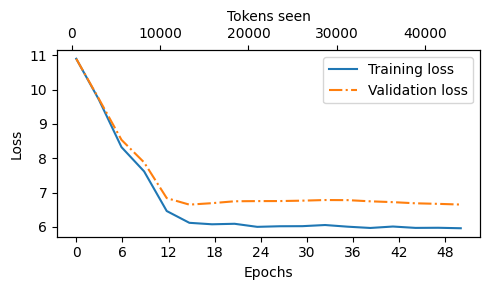

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    # plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Both the training and validation losses start to improve for the first
epoch. However, the losses start to diverge past the second epoch. 

This divergence and the
fact that the validation loss is much larger than the training loss indicate that the model is
overfitting to the training data. 

We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as "quite insensible to the
irony" in the "The Verdict" text file.


This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs. 

Usually, it's common to train a model
on a much, much larger dataset for only one epoch.

## Decoding Strategies to Control Randomness

In [21]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features=768, bias=False)
        (Wk): Linear(in_features=768, out_features=768, bias=False)
        (Wv): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (droput): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_fe

In [26]:
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer).replace('\n', ' '))

Output text:
 Every effort moves you?"  "Yes--quite insensible to the fact with the last word. Gisburn's an awful simpleton


### Decoding Strategy 1: Temperature Scaling

Previously, inside the generate_text_simple function, we always sampled the token with the highest probability as the next token using `torch.argmax`, also known as the `greedy decoding`.

To generate text with more variety, we can replace the argmax with a function that samples from a probabiltiy distribution (here, the probability scores the LLM generates for each vocabulary entry at each token generation step).

In [27]:
vocab = {
    'closer': 0,
    'every': 1,
    'effort': 2,
    'forward': 3,
    'inches': 4,
    'moves': 5, 
    'pizza': 6,
    'toward': 7,
    'you': 8
}

inverse_vocab = {v:k for k, v in vocab.items()}

In [29]:
# Let's assume that we pass the input tensor through the model and the following tensor is the logit tensor given by the model
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [30]:
probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)
print(inverse_vocab[next_token_id])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


In [31]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [33]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f'{freq} x {inverse_vocab[i]}')

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


As we can see based on the output, the word "forward" is sampled most of the time (582 out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also be sampled some of the time.

This means that if we replaced the argmax function with the multinomial function inside the generate_and_print_sample function, the LLM would sometimes generate text such as "every effort moves you toward", "every effort moves you inches", and "every effort moves you closer" instead of "every effort moves you forward".

In [36]:
# Apply temperature scaling
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

next_token_logits2 = next_token_logits / 0.1
probas = torch.softmax(next_token_logits2, dim=0)
print(probas)

tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])


In [37]:
next_token_logits3 = next_token_logits / 5
probas = torch.softmax(next_token_logits3, dim=0)
print(probas)

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [41]:
temperatures = [1, 0.1, 5]
scaled_logits = [next_token_logits/temp for temp in temperatures]
scaled_probas = [torch.softmax(scaled_logit, dim=0) for scaled_logit in scaled_logits]

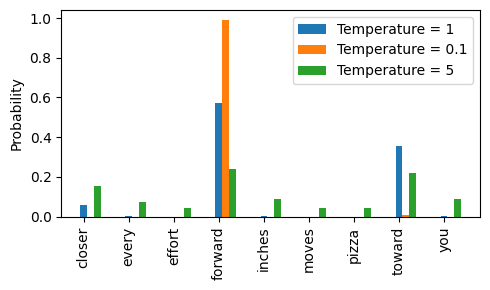

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
# plt.savefig("temperature-plot.pdf")
plt.show()

### Decoding Strategy 2: Top-k Sampling

In the previous section, we saw that higher temperature values result in more uniformly distributed next-token probabilities, which result in more diverse output as it reduces the likelihood of the model repeatedly selecting the most probable token. 

This method alllows for exploring less likely but potentially more interesting and creative paths in the generation process.

However, one downside of this approach is that it sometimes leads to grammatically incorect or completely nonsensical outputs such as "every effort moves you pizza".

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probabiltiy scores.

In [47]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [46]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print('Top logits: ', top_logits)
print('Top positions: ', top_pos)

Top logits:  tensor([6.7500, 6.2800, 4.5100])
Top positions:  tensor([3, 7, 0])


In [48]:
new_logits = torch.where(
    condition=next_token_logits<top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [49]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


 ### Merge Temperature Scaling and Top-k Scaling

In [50]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [64]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        # Filter logits with top_k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
            
        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            
            # apply softmax to get probabilities
            probas = torch.softmax(logits, dim=-1)
            
            # sample from the distribution
            idx_next = torch.multinomial(probas, num_samples=1)
            
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break
        
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [65]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate(
    model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k= 25,
    temperature=1.4
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer).replace('\n', ' '))

Output text:
 Every effort moves you not to work on surprise. Th is to face watching me by his knees. Professional-humrecating of my way of
